# Sentiment analysis media cloud extrated data

This notebook implements a foundational Sentiment Analysis pipeline on news titles, addressing the constraint of no labeled training data. We use the VADER lexicon method for classification and demonstrate feature engineering using TF-IDF and Truncated SVD (LSA) for future-proofing and exploration.

In [10]:
# Core Libraries
import pandas as pd
import re
import numpy as np
# Sentiment Analysis (Lexicon)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Feature Extraction and Dimensionality Reduction (ML components)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# --- Sample Newspaper Titles Data ---
media_cloud = pd.read_csv("orientaion_english.csv") 
media_cloud.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,domain,political_orientation
0,8ec6ee3fbd7df8acf011807509135594e1059a975e4e33...,2025-12-07 21:29:31.704001+00:00,es,bbc.com,bbc.com,07/12/2025,Fujian: what is the next-generation aircraft c...,https://www.bbc.com/mundo/articles/cdd526n2egr...,bbc.com,center
1,c4b7fc0a14d38d4bb082aac6ab793cb70ffbdce43fcab0...,2025-11-23 21:29:39.700224+00:00,es,bbc.com,bbc.com,23/11/2025,How Australia wants to prohibit access to soci...,https://www.bbc.com/mundo/articles/cx202xn46jl...,bbc.com,center
2,cf5195fa34510410a88564813fa464cc235dcf8cd7d0a5...,2025-09-14 21:27:48.971495+00:00,es,bbc.com,bbc.com,14/09/2025,The millionaires of Silicon Valley have messia...,https://www.bbc.com/mundo/articles/c701420e172...,bbc.com,center
3,0b1ce86ab0a7bf3f1705d8a076c0021119daeeebb6f718...,2025-09-02 21:31:52.015017+00:00,es,bbc.com,bbc.com,02/09/2025,"Tatiana Bilbao: ""Architecture can be a platfor...",https://www.bbc.com/mundo/articles/c5yp28n4n65...,bbc.com,center
4,4e519f07912c0f767852c853bb9e4c972030722f5f4a4c...,2025-09-01 21:30:42.707620+00:00,es,bbc.com,bbc.com,01/09/2025,How China used companies like Apple to overtak...,https://www.bbc.com/mundo/articles/cx29ljx57pg...,bbc.com,center


In [3]:
#let's conduct a sanity check on the data
print(media_cloud["language"].value_counts())

language
en    58163
es    22557
pt    12072
tr     3086
it     2138
fr     1664
uk      850
ru      819
nl      804
de      766
pl      158
Name: count, dtype: int64


# Preprocessing and Text Cleaning

In [4]:
def clean_text(text):
    # 1. Lowercasing (Standard practice for normalization)
    text = text.lower()
    # 2. Remove text inside parentheses (often non-essential context in titles)
    text = re.sub(r'\([^)]*\)', '', text)
    # 3. Remove most punctuation, but KEEP VADER-relevant symbols (like ! and ?)
    # VADER is explicitly designed to use punctuation (!!!) and capitalization (ALL CAPS)
    # as intensifiers. We will clean for the *TF-IDF* features but keep the raw
    # title for VADER, which is why we create a separate 'Clean_Title' column.
    return text

# We will create a clean version for feature extraction (TF-IDF)
media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)


# Core Sentiment Classification (Lexicon-Based)

In [5]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    # Use the ORIGINAL 'Title' for VADER to leverage capitalization and punctuation
    return analyzer.polarity_scores(text)['compound']

def classify_sentiment(score):
    # Standard VADER thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

media_cloud['VADER_Compound_Score'] = media_cloud['title'].apply(get_vader_sentiment)
media_cloud['Sentiment_VADER'] = media_cloud['VADER_Compound_Score'].apply(classify_sentiment)

print("--- Sentiment Analysis Results (VADER) ---")
print(media_cloud[['title', 'VADER_Compound_Score', 'Sentiment_VADER']])

--- Sentiment Analysis Results (VADER) ---
                                                    title  \
0       Fujian: what is the next-generation aircraft c...   
1       How Australia wants to prohibit access to soci...   
2       The millionaires of Silicon Valley have messia...   
3       Tatiana Bilbao: "Architecture can be a platfor...   
4       How China used companies like Apple to overtak...   
...                                                   ...   
103072  Scientists point out risks and benefits of art...   
103073  Academy sees risks and benefits of artificial ...   
103074  How Brazil can take advantage of the artificia...   
103075  Artificial intelligence: Brazil could miss the...   
103076  American CVM faces resistance to plan to regul...   

        VADER_Compound_Score Sentiment_VADER  
0                     0.0772        Positive  
1                     0.0000         Neutral  
2                     0.6124        Positive  
3                     0.0000        

# Post-Classification Exploration and Feature Engineering

In [6]:
# Vectorize the CLEANED text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(media_cloud['clean_title'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Vectorization Complete.")
print(f"Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): {tfidf_matrix.shape}")

TF-IDF Vectorization Complete.
Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): (103077, 405166)


In [7]:
# Reduce dimensions to 2 components for ease of inspection
svd = TruncatedSVD(n_components=2, random_state=42)
lsa_result = svd.fit_transform(tfidf_matrix)

media_cloud['LSA_Component_1'] = lsa_result[:, 0]
media_cloud['LSA_Component_2'] = lsa_result[:, 1]

print("\n--- Exploration: LSA Components and Sentiment ---")
print(media_cloud[['Sentiment_VADER', 'LSA_Component_1', 'LSA_Component_2']])

# Look at the top features that define the discovered LSA components (the 'topics')
print("\nTop features defining the LSA Components (Inferred Topics):")
for i, comp in enumerate(svd.components_):
    # Get the top 5 words/n-grams that contribute most to this component
    sorted_idx = comp.argsort()[::-1][:5]
    top_words = [feature_names[j] for j in sorted_idx]
    print(f"Component {i+1}: {top_words}")


--- Exploration: LSA Components and Sentiment ---
       Sentiment_VADER  LSA_Component_1  LSA_Component_2
0             Positive         0.003542         0.013575
1              Neutral         0.008843         0.027483
2             Positive         0.003373         0.010659
3              Neutral         0.000741         0.003015
4             Positive         0.012267         0.044953
...                ...              ...              ...
103072        Positive         0.211791        -0.020750
103073        Positive         0.201797        -0.018856
103074        Positive         0.268737        -0.028850
103075        Positive         0.210032        -0.025039
103076         Neutral         0.019823         0.085585

[103077 rows x 3 columns]

Top features defining the LSA Components (Inferred Topics):
Component 1: ['artificial', 'intelligence', 'artificial intelligence', 'regulation', 'regulation artificial']
Component 2: ['ai', 'regulation', 'tech', 'new', 'eu']


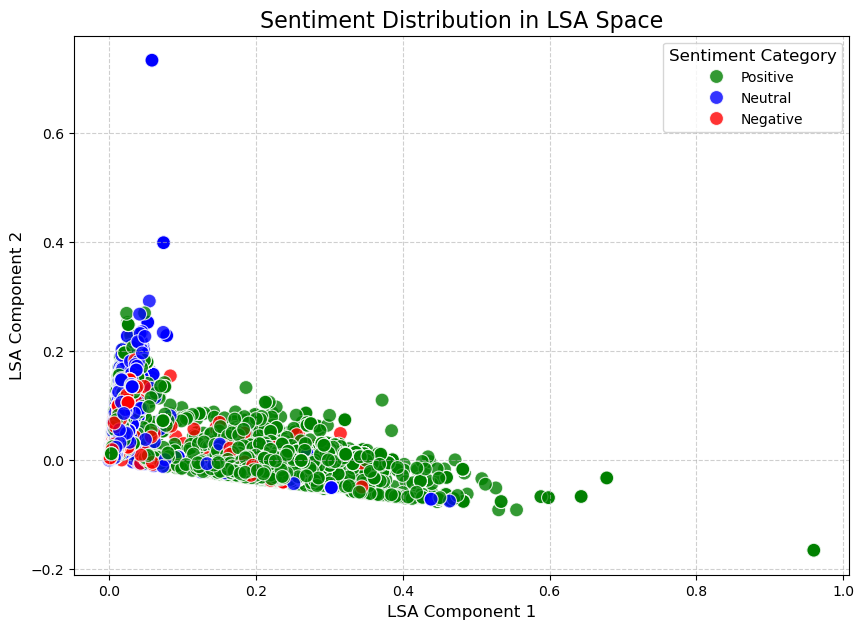

In [8]:
# 3. Visualization of LSA Components by Sentiment
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='LSA_Component_1',
    y='LSA_Component_2',
    hue='Sentiment_VADER',  # Color points by sentiment
    data=media_cloud,
    s=100, # Size of points
    alpha=0.8, # Transparency
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'} # Custom colors
)

# Add titles for clarity
plt.title('Sentiment Distribution in LSA Space', fontsize=16)
plt.xlabel('LSA Component 1', fontsize=12)
plt.ylabel('LSA Component 2', fontsize=12)

# Ensure the legend is displayed clearly
plt.legend(title='Sentiment Category', title_fontsize='12', fontsize='10')

plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [11]:
# Compute mean TF-IDF per sentiment (sparse-safe for large datasets)
grouped = {}
for sentiment, idx_labels in media_cloud.groupby('Sentiment_VADER').groups.items():
    pos = media_cloud.index.get_indexer(list(idx_labels))
    sub = tfidf_matrix[pos]
    mean_vec = sub.mean(axis=0)
    grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
grouped_tfidf = pd.DataFrame(grouped).T

In [12]:
for sentiment in grouped_tfidf.index:
    top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\nTop TF-IDF words for {sentiment} sentiment:")
    print(top_words)



Top TF-IDF words for Negative sentiment:
ai       0.019068
trump    0.005704
says     0.005169
warns    0.005132
new      0.005120
ban      0.005119
risks    0.005104
tech     0.005100
war      0.004943
china    0.004671
Name: Negative, dtype: float64

Top TF-IDF words for Neutral sentiment:
ai            0.019321
new           0.007422
tech          0.005336
regulation    0.005186
trump         0.005061
market        0.005055
digital       0.004914
announces     0.004807
results       0.004647
global        0.004445
Name: Neutral, dtype: float64

Top TF-IDF words for Positive sentiment:
intelligence               0.024935
artificial                 0.024485
artificial intelligence    0.024463
ai                         0.017789
market                     0.007025
new                        0.005835
regulation                 0.005374
safety                     0.005318
law                        0.005000
global                     0.004759
Name: Positive, dtype: float64


# Let's see how this results change according to each year

we first create different datasets where the filter is the year

and we do the same analysis done above

In [13]:
media_cloud['publish_date'] = pd.to_datetime(media_cloud.get('publish_date', media_cloud.get('date', None)), errors='coerce')
media_cloud['year'] = media_cloud['publish_date'].dt.year


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


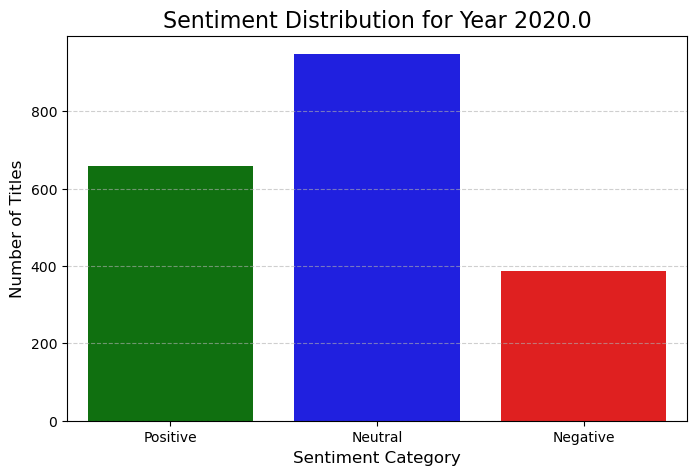


Year 2020.0 - Top TF-IDF words for Negative sentiment:
facial recognition    0.011752
facial                0.011684
coronavirus           0.011623
recognition           0.011542
trump extension       0.011353
extension tiktok      0.011353
ban                   0.011318
trump                 0.010580
extension             0.009676
covid                 0.009495
Name: Negative, dtype: float64

Year 2020.0 - Top TF-IDF words for Neutral sentiment:
coronavirus              0.024654
coronavirus spain        0.019883
spain today              0.019644
today                    0.016892
spain                    0.015874
house proposes           0.015171
2020                     0.012865
proposes guidelines      0.012123
guidelines regulating    0.012087
white house              0.011994
Name: Neutral, dtype: float64

Year 2020.0 - Top TF-IDF words for Positive sentiment:
intelligence               0.017771
artificial intelligence    0.016863
artificial                 0.016807
2020          

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


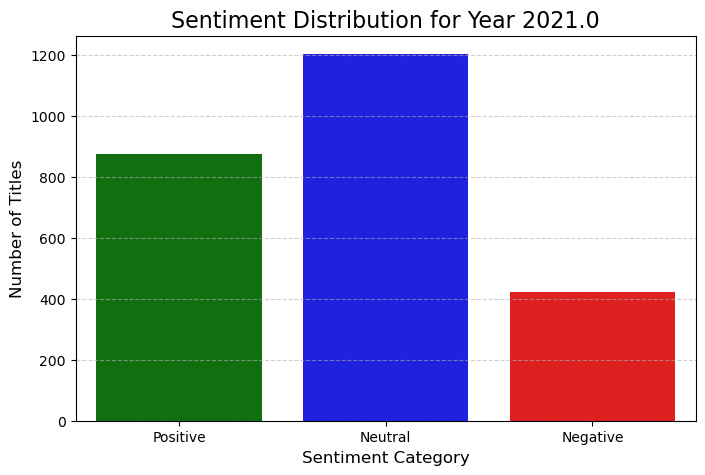


Year 2021.0 - Top TF-IDF words for Negative sentiment:
facebook              0.022050
facial recognition    0.012720
facial                0.012647
recognition           0.012493
division              0.012334
privacy               0.012054
ex                    0.011880
ex facebook           0.011159
facebook employee     0.010591
employee says         0.010219
Name: Negative, dtype: float64

Year 2021.0 - Top TF-IDF words for Neutral sentiment:
2021                  0.017455
market                0.010461
facebook              0.009839
announces             0.009260
global                0.008249
data                  0.008128
recognition           0.007982
facial recognition    0.007971
facial                0.007925
technology            0.007155
Name: Neutral, dtype: float64

Year 2021.0 - Top TF-IDF words for Positive sentiment:
2021                       0.012605
intelligence               0.010397
artificial intelligence    0.010206
artificial                 0.010172
growth  

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


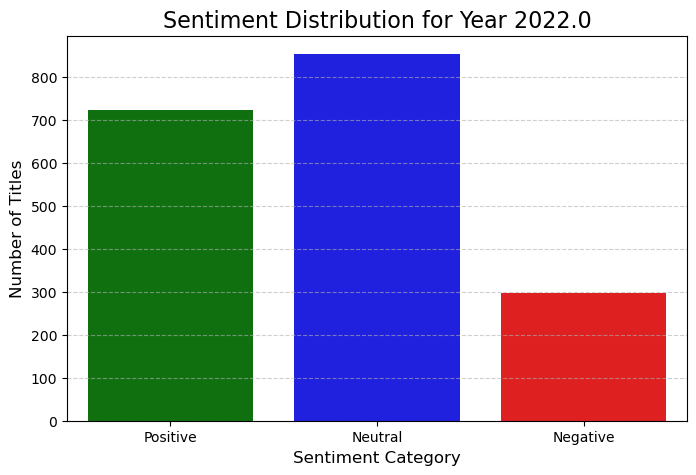


Year 2022.0 - Top TF-IDF words for Negative sentiment:
midterms loom              0.015263
midterms                   0.015079
election misinformation    0.014696
efforts midterms           0.014326
misinformation efforts     0.014326
loom                       0.012914
efforts                    0.012735
misinformation             0.012052
meta                       0.011930
ai                         0.011083
Name: Negative, dtype: float64

Year 2022.0 - Top TF-IDF words for Neutral sentiment:
2022                      0.021410
financial                 0.010809
market                    0.010601
announces                 0.009362
results                   0.008902
financial results         0.008220
quarter                   0.007809
pornographic deepfakes    0.007381
pornographic              0.007059
update                    0.006742
Name: Neutral, dtype: float64

Year 2022.0 - Top TF-IDF words for Positive sentiment:
intelligence               0.017927
artificial intelligence   

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


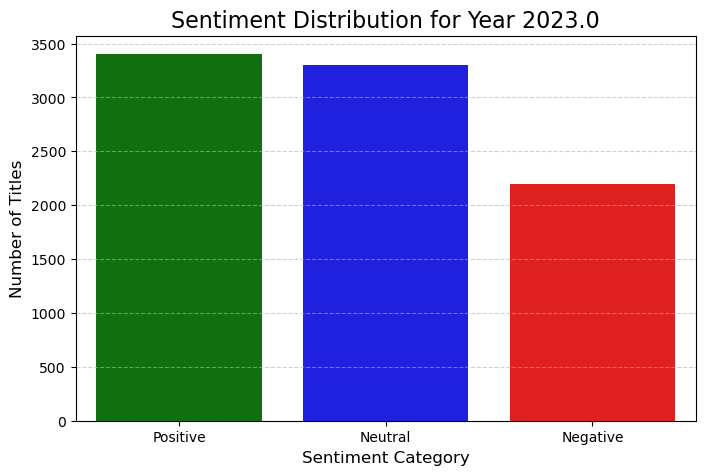


Year 2023.0 - Top TF-IDF words for Negative sentiment:
ai          0.027434
risks       0.010634
chatgpt     0.007361
ai risks    0.006814
warns       0.006438
risk        0.006186
china       0.005881
dangers     0.005863
war         0.005749
musk        0.005541
Name: Negative, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],



Year 2023.0 - Top TF-IDF words for Neutral sentiment:
ai            0.028926
regulation    0.008310
2023          0.008092
new           0.007475
chatgpt       0.006873
tech          0.006784
sunak         0.006429
says          0.005698
rules         0.005458
global        0.005356
Name: Neutral, dtype: float64

Year 2023.0 - Top TF-IDF words for Positive sentiment:
intelligence               0.037619
artificial                 0.037489
artificial intelligence    0.037429
ai                         0.026770
safety                     0.010351
eu                         0.009776
world                      0.009732
ai safety                  0.008992
summit                     0.008223
regulate                   0.008192
Name: Positive, dtype: float64


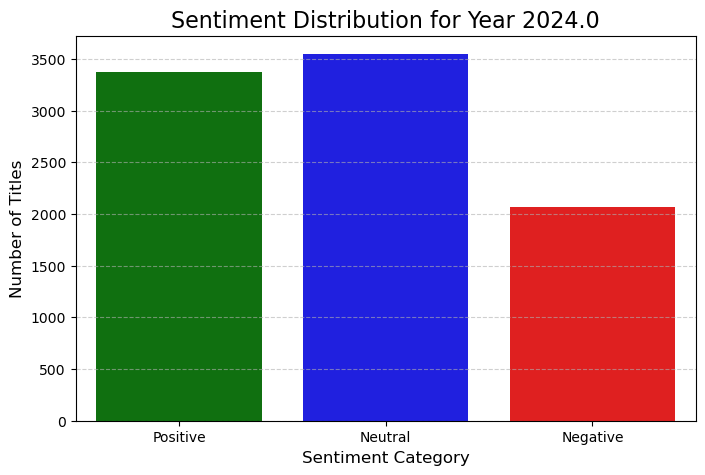


Year 2024.0 - Top TF-IDF words for Negative sentiment:
ai                0.018530
china             0.009371
tension review    0.007380
review mec        0.007380
china tension     0.007336
mec               0.007182
news              0.006849
tension           0.006728
review            0.006175
risks             0.006173
Name: Negative, dtype: float64

Year 2024.0 - Top TF-IDF words for Neutral sentiment:
ai                  0.021658
2024                0.012566
trump               0.007994
new                 0.006669
results             0.005346
tech                0.005239
quarter             0.004956
elchoche            0.004794
meta accelerates    0.004628
accelerates ai      0.004585
Name: Neutral, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_69439/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],



Year 2024.0 - Top TF-IDF words for Positive sentiment:
intelligence               0.023626
artificial                 0.023279
artificial intelligence    0.023247
ai                         0.018197
2024                       0.007605
new                        0.007201
safety                     0.007095
trump                      0.006775
world                      0.006616
market                     0.006294
Name: Positive, dtype: float64


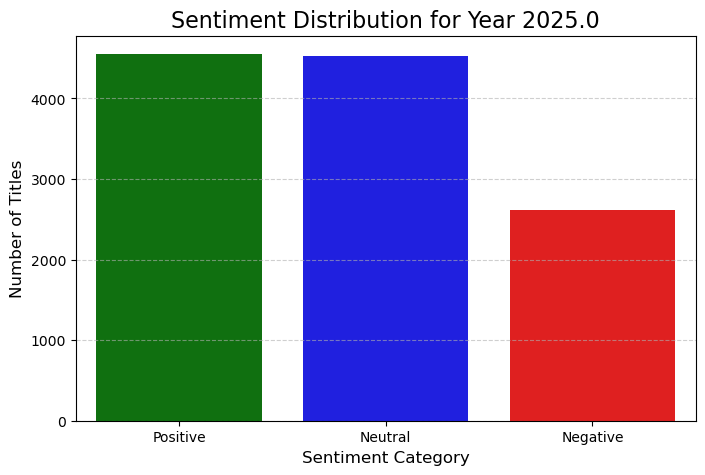


Year 2025.0 - Top TF-IDF words for Negative sentiment:
ai                 0.022898
trump              0.014962
ban                0.009828
new                0.006615
media              0.006022
states             0.005625
demand             0.005577
regulation         0.005477
executive order    0.005327
order              0.005309
Name: Negative, dtype: float64

Year 2025.0 - Top TF-IDF words for Neutral sentiment:
ai           0.023412
2025         0.013871
trump        0.010144
new          0.007898
summit       0.006798
announces    0.006495
quarter      0.006419
digital      0.006205
results      0.006137
market       0.005823
Name: Neutral, dtype: float64

Year 2025.0 - Top TF-IDF words for Positive sentiment:
ai                         0.018967
intelligence               0.017221
artificial intelligence    0.016805
artificial                 0.016782
trump                      0.008363
2025                       0.008028
market                     0.007859
new                 

In [14]:
# ...existing code...
import numpy as np

for year in sorted(media_cloud['year'].dropna().unique()):
    yearly_data = media_cloud[media_cloud['year'] == year]
    if yearly_data.empty:
        continue

    # distribution plot
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],
                  palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'})
    plt.title(f'Sentiment Distribution for Year {year}', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Number of Titles', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # transform YEARLY cleaned titles (do NOT refit vectorizer)
    yearly_tfidf = vectorizer.transform(yearly_data['clean_title'])  # sparse matrix (n_titles x n_features)

    # compute mean TF-IDF per sentiment (sparse-safe)
    if yearly_tfidf.shape[0] <= 5000:
        tfidf_df = pd.DataFrame(yearly_tfidf.toarray(), columns=feature_names, index=yearly_data.index)
        tfidf_df['Sentiment_VADER'] = yearly_data['Sentiment_VADER'].values
        grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()
    else:
        grouped = {}
        # .groups returns mapping sentiment -> list of index labels in yearly_data
        for sentiment, idx_labels in yearly_data.groupby('Sentiment_VADER').groups.items():
            pos = yearly_data.index.get_indexer(list(idx_labels))  # positions relative to yearly_tfidf rows
            sub = yearly_tfidf[pos]
            mean_vec = sub.mean(axis=0)
            grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
        grouped_tfidf = pd.DataFrame(grouped).T

    # print top words per sentiment for this year
    for sentiment in grouped_tfidf.index:
        top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
        print(f"\nYear {year} - Top TF-IDF words for {sentiment} sentiment:")
        print(top_words)
# ...existing code...

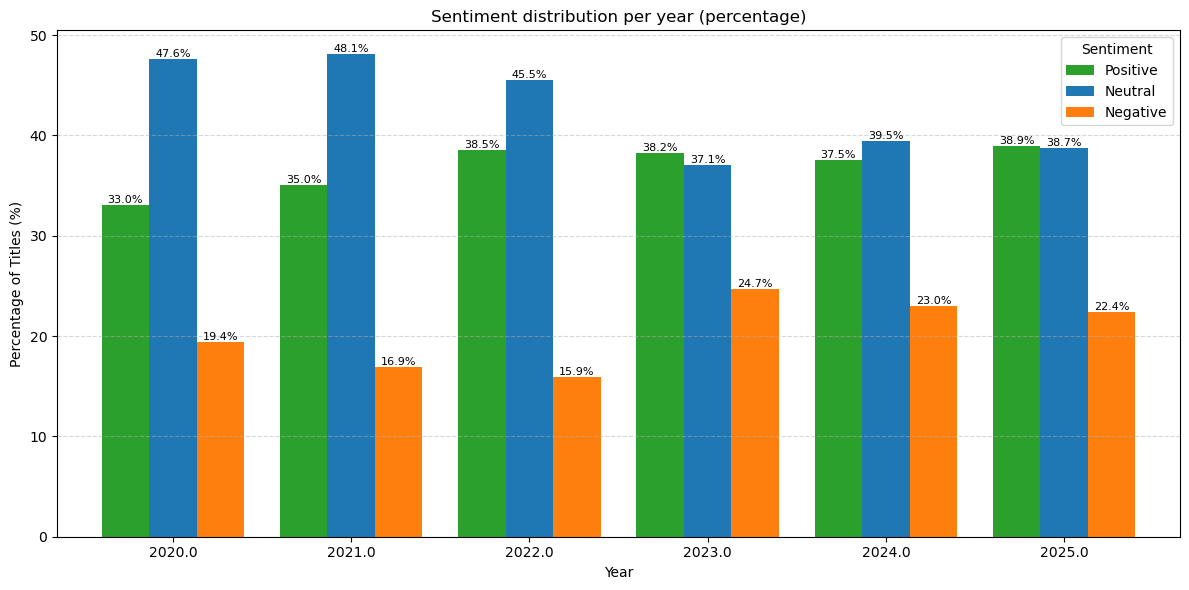

In [15]:
import numpy as np

# ensure desired sentiment order
sentiments_order = ['Positive', 'Neutral', 'Negative']

# compute counts per year x sentiment and convert to percentages per year
counts = media_cloud.groupby(['year', 'Sentiment_VADER']).size().unstack(fill_value=0)
counts = counts.reindex(columns=sentiments_order, fill_value=0)  # enforce column order
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100  # percent per year

# plot grouped bars (each year has three bars: Positive, Neutral, Negative)
ax = counts_pct.plot(kind='bar', figsize=(12, 6), width=0.8, color=[ '#2ca02c', '#1f77b4' , '#ff7f0e'] )
ax.set_ylabel('Percentage of Titles (%)')
ax.set_xlabel('Year')
ax.set_title('Sentiment distribution per year (percentage)')
ax.legend(title='Sentiment', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

# annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


In [16]:
# let's save the updated DataFrame into a new CSV file
media_cloud.to_csv("sentiment-analysis.csv", index=False)

# analysis of sentiment across outlets of the same political leaning

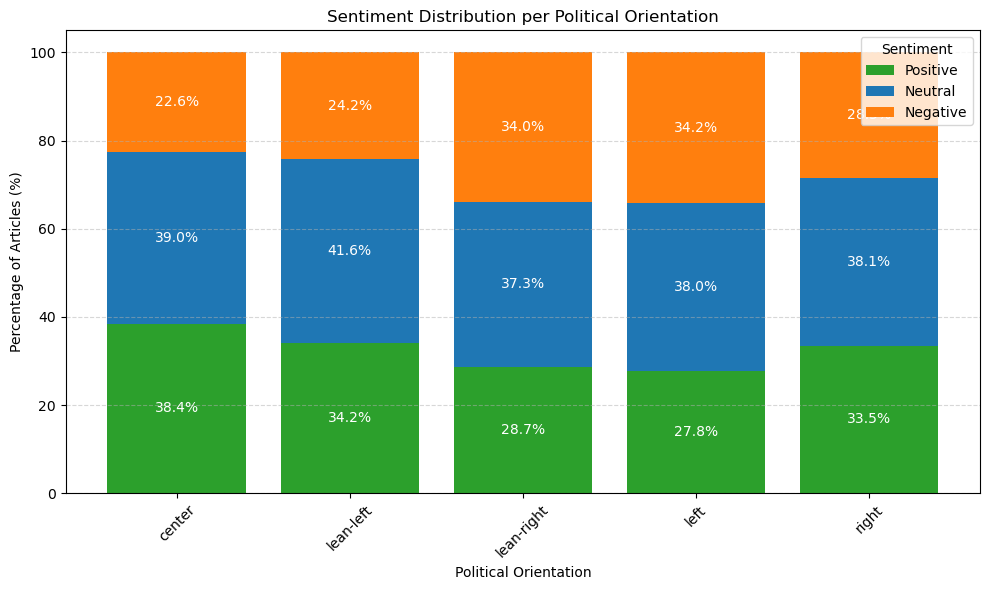

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare  calculate sentiment counts per political_orientation
count_df = media_cloud.groupby(['political_orientation', 'Sentiment_VADER']).size().unstack(fill_value=0)

# Calculate percentages per political orientation
perc_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Define colors for sentiments
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#ff7f0e'}

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(perc_df))
orientations = perc_df.index

# Plot stacked bars
for sentiment in ['Positive', 'Neutral', 'Negative']:
    values = perc_df[sentiment].values
    bars = ax.bar(orientations, values, bottom=bottom, color=colors[sentiment], label=sentiment)
    
    # Annotate with percentage inside each segment
    for bar, pct in zip(bars, values):
        if pct > 5:  # annotate only if segment visible enough
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                    f'{pct:.1f}%', ha='center', va='center', color='white', fontsize=10)
    
    bottom += values

ax.set_ylabel('Percentage of Articles (%)')
ax.set_xlabel('Political Orientation')
ax.set_title('Sentiment Distribution per Political Orientation')
ax.legend(title='Sentiment')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


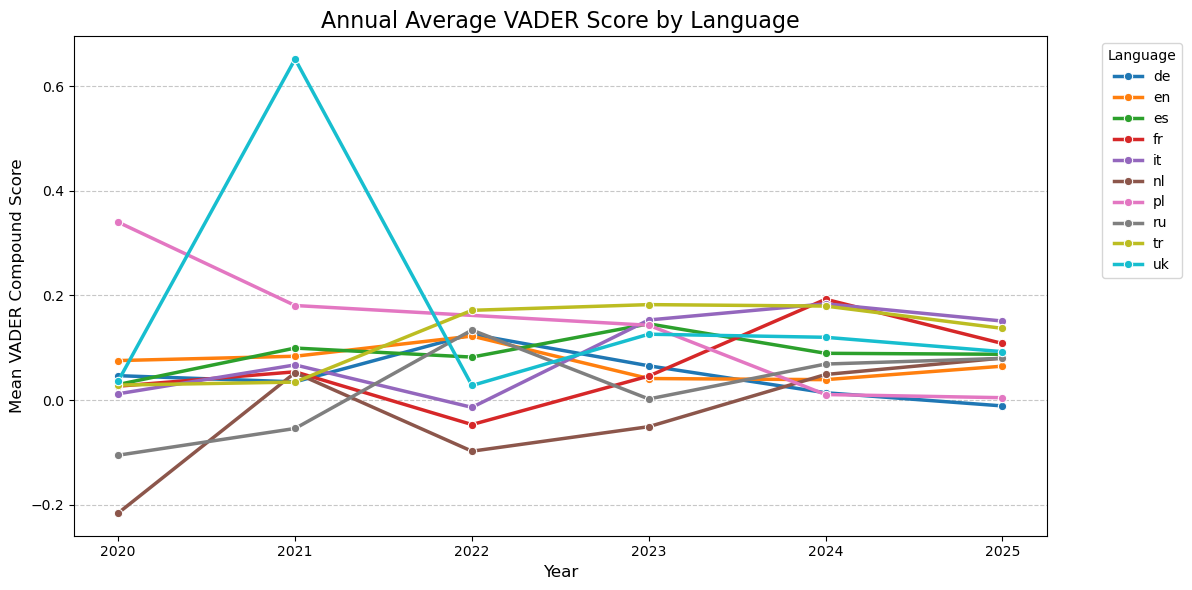

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a 'year' column to group by
media_cloud['year'] = media_cloud['publish_date'].dt.year

# 2. Calculate the average score per language per year
annual_sentiment = media_cloud.groupby(['year', 'language'])['VADER_Compound_Score'].mean().reset_index()

# 3. Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=annual_sentiment,
    x='year',
    y='VADER_Compound_Score',
    hue='language',
    marker='o',       # Adds a dot at each year
    linewidth=2.5
)

plt.title('Annual Average VADER Score by Language', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean VADER Compound Score', fontsize=12)

# Ensure x-axis only shows integer years
plt.xticks(annual_sentiment['year'].unique())

plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

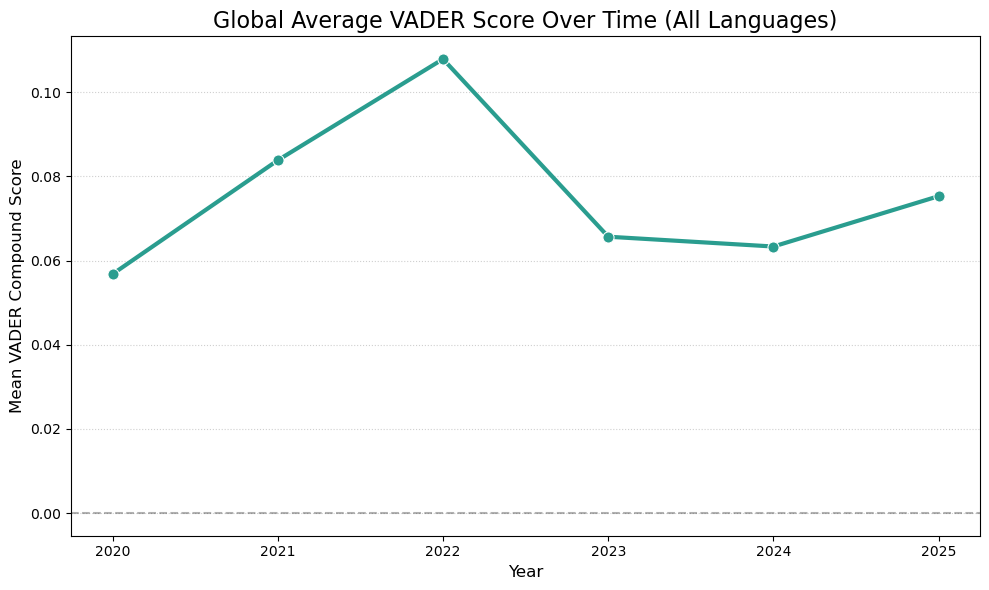

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Ensure publish_date is datetime and extract the year
media_cloud['publish_date'] = pd.to_datetime(media_cloud['publish_date'])
media_cloud['year'] = media_cloud['publish_date'].dt.year

# 2. Calculate the average score for ALL languages combined per year
global_annual_sentiment = media_cloud.groupby('year')['VADER_Compound_Score'].mean().reset_index()

# 3. Plot the single line chart
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=global_annual_sentiment,
    x='year',
    y='VADER_Compound_Score',
    marker='o',         # Dot for each year
    markersize=8,
    linewidth=3,
    color='#2a9d8f'     # A clean, professional teal color
)

# Add a horizontal line at 0 for neutral reference
plt.axhline(0, color='black', linestyle='--', alpha=0.3)

plt.title('Global Average VADER Score Over Time (All Languages)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean VADER Compound Score', fontsize=12)

# Clean up x-axis to show only the years present in data
plt.xticks(global_annual_sentiment['year'].unique())

plt.grid(True, axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()